# Understanding Customer Churn 

**Author:** Robert Smith  
**Date:** 2020-08-13

### Data:

The data is in one table called *9mo_pull.csv*, which contains data for all members who subscribed to a personal finance SaaS exactly 9 months ago. It does not contain data for members who subscribed since then. In other words, each member in the dataset has the same start date. As a result, this data is considered to be "right censored". 

### Task: 

Analyze churn rate for a subscription-based personal finance business. The churn rate is defined as the proportion of members who cancel their subscription. For example, a 20% churn rate can also be referred to as an 80% retention rate.

### Questions to Answer: 
1. What was the churn rate over the first 8 months for each price tier?
2. What was the average tenure for each price tier?
3. What impact does the tier, country, and source of a customer have on their tenure and risk of customer churn? 
4. How many currently active subscriptions will still be active over the next three months (e.g. month 9, 10, 11)?

### Data Dictionary:

*member_id* - Unique ID of the user.  
*tier* - Price tier (Silver, Gold, or Platinum).  
*country* - Member country.  
*source* - Original acquisition channel.  
*tenure* - Number of cycles billed. Min is 1. Max is 9.  
*active* - Is the subscription still active?  

## 0. Import Libraries 

In [1]:
# Load Standard Libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Set Preferred Plotting Style
sns.set_style("darkgrid")
%matplotlib inline

# Load Survival Libraries
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import CoxPHFitter
from lifelines import WeibullAFTFitter

# Load Sklearn Helpers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## 1. Import Data

In [2]:
df = pd.read_csv('../data/9mo_pull.csv')

## 2. Exploratory Data Analysis
First, we'll check the basics of the data set including:

* View of data header
* Size
* Data types
* Missing values
* Duplicates

In [3]:
df.head()

,member_id,tier,country,source,tenure,active
0,12428284,Platinum,Germany,referral,6,0
1,39743027,Platinum,France,referral,1,0
2,59559187,Silver,UK,organic,1,0
3,46170183,Silver,UK,organic,4,0
4,14600427,Gold,France,organic,1,0


In [4]:
df.shape

(99944, 6)

In [5]:
df.dtypes

member_id     int64
tier         object
country      object
source       object
tenure        int64
active        int64
dtype: object

In [6]:
df.isnull().mean() # No missing data - it's a miracle! 

member_id    0.0
tier         0.0
country      0.0
source       0.0
tenure       0.0
active       0.0
dtype: float64

In [7]:
df[df["member_id"].duplicated(keep = False)] # No duplicate member_ids - another miracle! 

,member_id,tier,country,source,tenure,active


Now that we've checked the basic structure of the dataset - let's look at the retention rate across the three categorical variables (country, source, tenure). We'll first write a helper function to assist with creating the plots...

In [8]:
def churn_rate_plots(segment_by):
    """Convenience function for plotting segmented churn rates
    Args:
        segment_by (string): Categorical feature to segment churn rates
    
    Returns:
        Plot of the number of customers and proportion active by level in segment.
    
    """
    # Initialize sub-plots for 2 columns
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(14,6))
    
    # On the left, plot the distribution
    sns.countplot(x=segment_by, data=df, ax=ax1)
    ax1.title.set_text(f"# Customers by {segment_by}")
    
    # On the right, plot the retention rate
    sns.barplot(x=segment_by, y='active', data=df, ax=ax2)
    ax2.title.set_text(f"Proportion of Active Customers by {segment_by}")
    
    # Set title
    plt.suptitle('Retention Rate by {}'.format(segment_by.capitalize()))
    plt.show()

When evaluating the customers by country, the most common locations include Germany, the UK, and the US. However - these locations are not associated with longer tenure. The Netherlands and Canada are clear outliers, with over 15% of their customers still retained after 9 months, roughly 3x all other countries. 

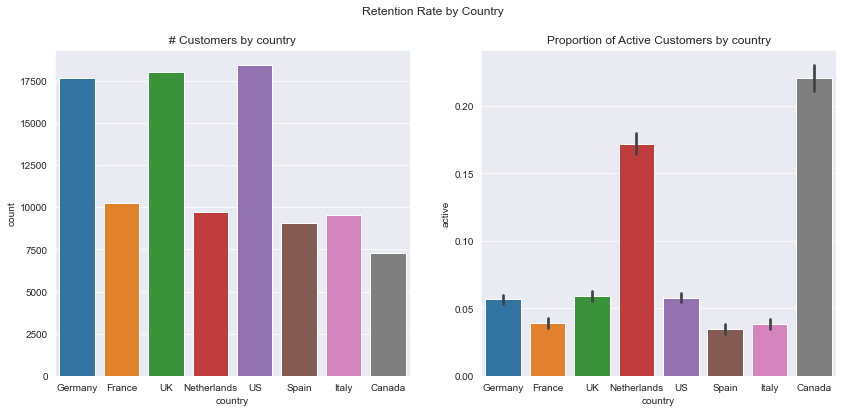

In [9]:
churn_rate_plots('country')

When evaluating the customers by their source, the most common source by far is organic. However, the organically sourced customers are associated with the shortest tenure. Customers enrolled via a referral have over 30% enrollment after 9 months. Customers enrolling through a partner are about half of their referred counterparts, with a retention rate of approximately 15% after 9 months. 

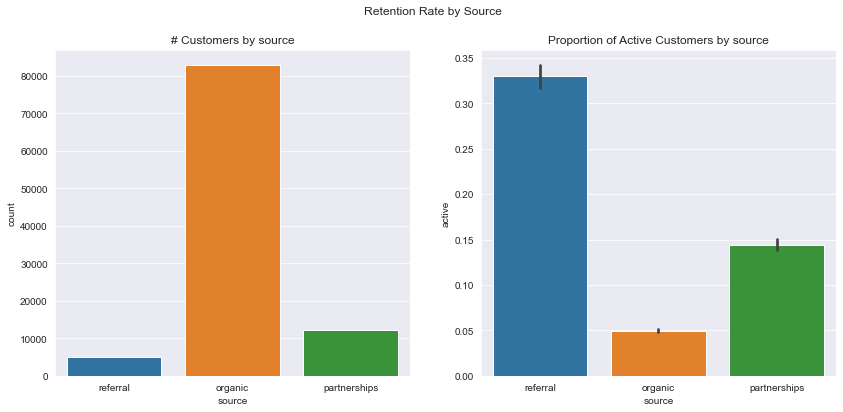

In [10]:
churn_rate_plots('source')

When evaluating customers by their enrolled tier, we see that the Gold tier is the most popular. However, the Silver tier has the highest retention rate after 8 months.

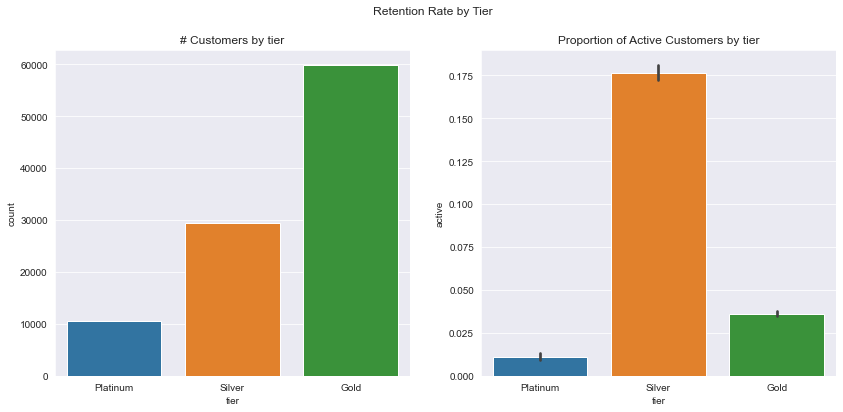

In [11]:
churn_rate_plots('tier')

The graph below shows that the vast majority of the subscriptions only last 1 month. Only a small fraction actually make it to month 9! Note that all of the customers in month 9 are active, thus we only know of customers that have churned through month 8.

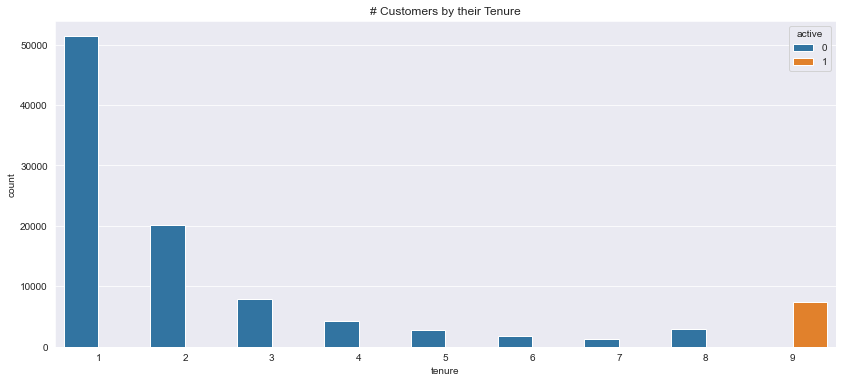

In [12]:
plt.figure(figsize = (14,6))
sns.countplot(x="tenure", hue = "active", data = df)
plt.title("# Customers by their Tenure");

Now that we've thoroughly explored our data set, we can almost answer our first question. First, a "churn column" will be created to more easily calculate the average churn rate.

## 3. Data Cleaning

In [13]:
df["churn"] = np.where(df['active'] == 1, False ,True)

## Q1: What was the churn rate over the last 9 months for each price tier?

In [14]:
# Increase font-size
plt.rcParams.update({'font.size': 12})

# Create function to help with labeling plots
def autolabel(bar_plot):
    """ Convenience function to add labels to bar chart.
    Args:
        bar_plot (plot): Matplotlib bar plot object
    
    Returns:
        Labelled bar plot
    """
    
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                round(height,2),
                ha='center', va='bottom', rotation=0)

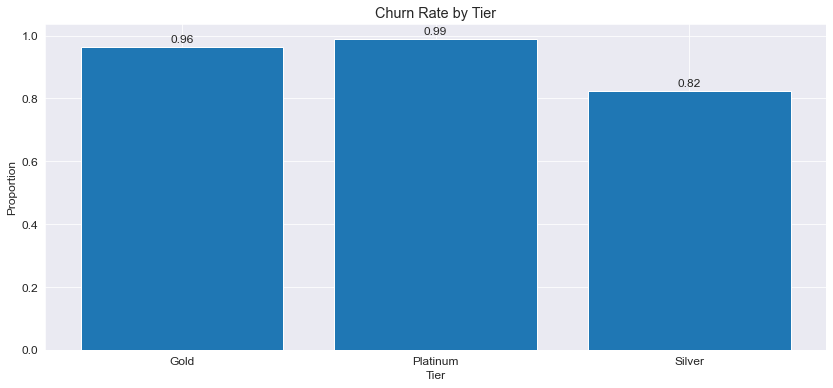

In [15]:
churn_by_tier = df.groupby(['tier'])['churn'].mean()
fig, ax = plt.subplots(figsize=(14,6))
bar_plot = plt.bar(churn_by_tier.index, churn_by_tier.values)
plt.title("Churn Rate by Tier")
plt.ylabel("Proportion")
plt.xlabel("Tier")
autolabel(bar_plot)

* The Gold tier had churn rate of 96% after 9 months.
* The Platinum tier had a churn rate of 99% after 9 months.
* The Silver tier had a churn rate of 82% after 9 months.

## Q2: What was the average tenure for each price tier?

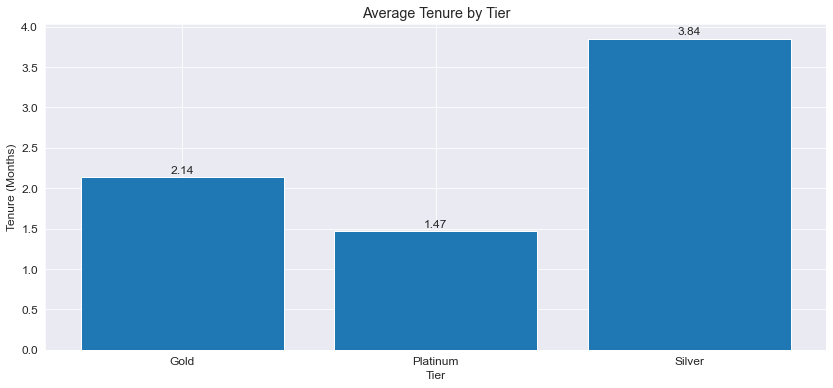

In [16]:
tenure_by_tier = df.groupby(['tier'])['tenure'].mean()
fig, ax = plt.subplots(figsize=(14,6))
bar_plot = plt.bar(tenure_by_tier.index, tenure_by_tier.values)
plt.title("Average Tenure by Tier")
plt.ylabel("Tenure (Months)")
plt.xlabel("Tier")
autolabel(bar_plot)

* The Gold tier had a tenure of 2.14 months on average.
* The Platinum tier had a tenure of 1.47 months on average.
* The Silver tier had a tenure of 3.84 months on average.

## 4. Kaplan-Meier Survival Curves

The last data exploration technique to look at before modeling is generating [Kaplan-Meier](https://en.wikipedia.org/wiki/Kaplan–Meier_estimator) curves for the three categorical features. These curves are helpful in understanding the probability of "survivial" (e.g. the probability of the customer not churning) by month. First we'll create a function to help with plotting the curves...

In [17]:
def km_plot(df, feature):
    """Plots Kaplan-Meier curve.
    
    Args:
        df (dataframe): Dataframe with right-censored data.
        feature (string): Feature used to segment plot
    
    Returns:
        Segmented Kaplan-Meier curve.
    """
    
    kmf = KaplanMeierFitter()
    X = df[["tier", "source", "country"]]
    y = df[["churn", "tenure"]]
    plt.figure(figsize = (14,6))
    for value in X[feature].unique():
        index = X[feature] == value
        kmf.fit(y.loc[index,"tenure"], y.loc[index, "churn"], label = value)
        kmf.plot()
    plt.title(f"Kaplan-Meier Curve by {feature}")
    plt.ylabel("Est. Probability of Survival $\hat{S}(t)$")
    plt.xlabel("time $t$")

In all of the following curves, there is significant attrition after the first month. The best survival curve for customers are those that are in the silver tier, referred to the product, and are either from Canada or the Netherlands.

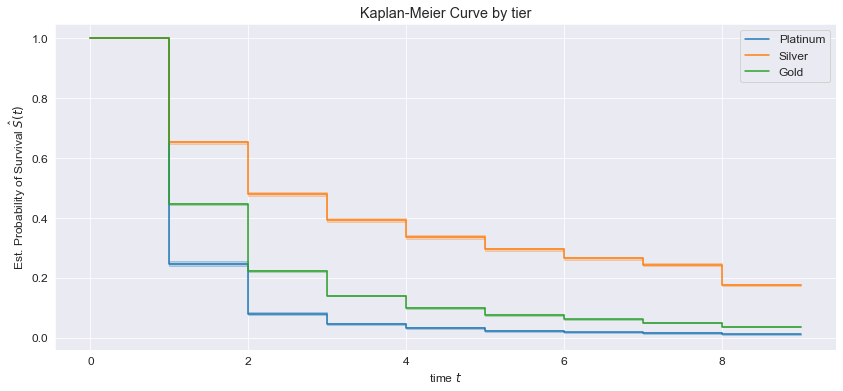

In [18]:
km_plot(df, "tier")

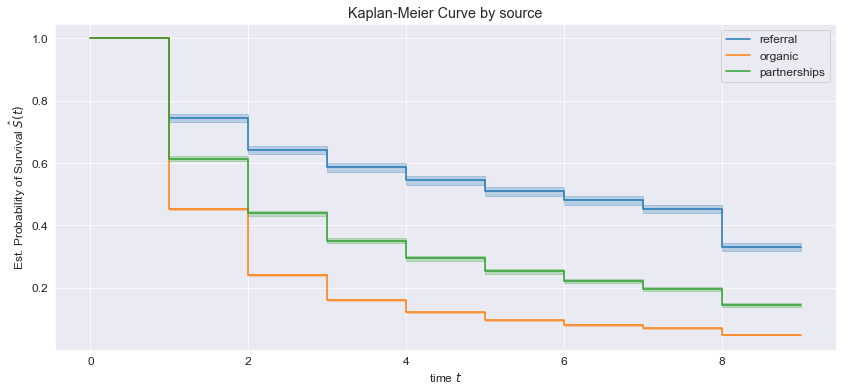

In [19]:
km_plot(df, "source")

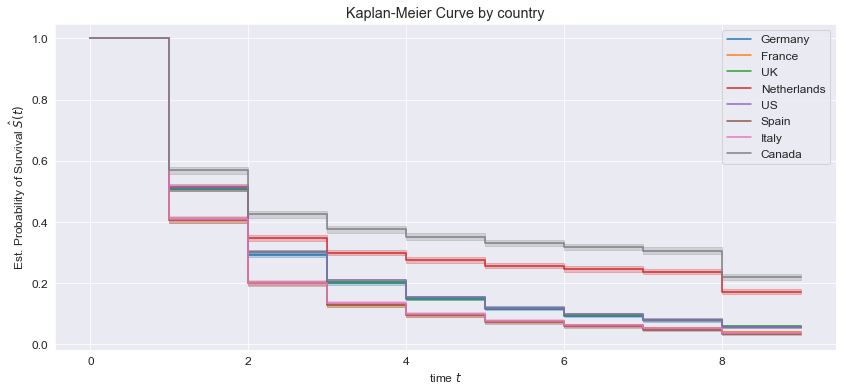

In [20]:
km_plot(df, "country")

## 5. Survival Modeling

In order to answer the last few business questions, a model needs to be constructed in order to forecast the following few months of customer churn. In this case we'll use a [survival modeling](https://en.wikipedia.org/wiki/Survival_analysis) approach, which is useful for "time to event" data. In the case of this data set, the event is `churn`. Customers that have not experienced the event are considered a "censored" record.  

In [21]:
n_censored = df.shape[0] - df["churn"].sum()
print("%.1f%% of records are censored." % (n_censored / df.shape[0] * 100))

7.5% of records are censored.


In [22]:
df.head()

,member_id,tier,country,source,tenure,active,churn
0,12428284,Platinum,Germany,referral,6,0,True
1,39743027,Platinum,France,referral,1,0,True
2,59559187,Silver,UK,organic,1,0,True
3,46170183,Silver,UK,organic,4,0,True
4,14600427,Gold,France,organic,1,0,True


First, split up the data into X and y and create training and testing data sets

In [23]:
X = df[["tier", "country", "source", "churn"]]
X = pd.get_dummies(X, drop_first=True) # Need to convert into dummy variables 

y = df["tenure"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Next, the survival model is instantiated. Two survival models were explored that are well suited for extrapolation:

* **Modified Cox Proportional Hazard Model**: A modified version of the Cox Proportional Hazards model where the baseline hazard includes cubic spline terms. This model allows for extrapolation, but its predictions vary widely depending on the number of splines used (while still reporting very similar concordance indices). 

* **Weibull Accelerated Failure Time Model**: A parameteric survival analysis model based on the Weibull distribution. 


### Weibull Accelerated Failure Time Modeling 

In [24]:
# Instantiate the class
aft_class = sklearn_adapter(WeibullAFTFitter, event_col='churn')
aft = aft_class()

# Set-up parameter grid
aft_params = {"penalizer": list(10.**np.arange(-4,1,1)),
              "l1_ratio": [0, 1/3, 2/3, 1]}
    
# Set-up 5-fold cross-validation grid search
gcv = GridSearchCV(aft, aft_params, return_train_score=True, cv=5)

# Fit model
gcv.fit(X_train, y_train)

# Save model parameters and training concordance index
params = gcv.best_estimator_.get_params()
train_score = gcv.best_score_
    
# Check out-of-sample concordance index
test_score = gcv.score(X_test,y_test)

# Due to limitations of sklearn wrapper - the model will be re-instantiated using lifelines
aft_model = WeibullAFTFitter(penalizer = params["penalizer"], l1_ratio = params["l1_ratio"])
aft_model.fit(pd.concat([X_train,y_train], axis = 1), duration_col = "tenure", event_col = "churn")
    
# Save AIC 
aic = aft_model.AIC_

# Get log-likelihood score on test set
log_likelihood_test_score = aft_model.score(pd.concat([X_test, y_test], axis = 1))
    
aft_results = ["weibull_aft", params, train_score, test_score, aic, log_likelihood_test_score]
col_names = ["Model", "Best Parameters", "Train Concordance Index", 
           "Test Concordance Index", "AIC", "Test Log-Likelihood"]

pd.DataFrame([aft_results], columns = col_names)

,Model,Best Parameters,Train Concordance Index,Test Concordance Index,AIC,Test Log-Likelihood
0,weibull_aft,"{'alpha': 0.05, 'penalizer': 0.1, 'l1_ratio': ...",0.679735,0.679859,276007.200008,-1.678299


In [25]:
aft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 79955 total observations, 5972 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
                penalizer = 0.1
   number of observations = 79955
number of events observed = 73983
           log-likelihood = -137990.60
         time fit was run = 2020-09-03 04:10:01 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                   
lambda_ country_France       -0.24       0.79       0.01            -0.26            -0.22                 0.77                 0.80
        country_Germany      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        country_Italy        -0.24       0.79       0.01            -0.26            -0.21                 0.77                 0.81
        country_Netherlands   0.07       1.07       0.01             0.04             0.09                 1.05                 1.10
        country_Spain        -0.25       0.78       0.01            -0.27            -0.23                 0.76                 0.80
        country_UK            0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        country_US            0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
        source_partnerships   0.47       1.60       0.01             0.45             0.48                 1.57                 1.62
        source_referral       1.00       2.72       0.01             0.98             1.03                 2.65                 2.79
        tier_Platinum        -0.33       0.72       0.01            -0.35            -0.31                 0.71                 0.73
        tier_Silver           0.68       1.97       0.01             0.67             0.69                 1.95                 2.00
        Intercept             0.78       2.18       0.01             0.76             0.80                 2.14                 2.22
rho_    Intercept             0.28       1.32       0.00             0.28             0.29                 1.32                 1.33
                                 z      p   -log2(p)
param   covariate                                   
lambda_ country_France      -20.06 <0.005     294.93
        country_Germany      -0.00   1.00       0.00
        country_Italy       -19.34 <0.005     274.29
        country_Netherlands   5.74 <0.005      26.70
        country_Spain       -20.22 <0.005     299.67
        country_UK            0.00   1.00       0.00
        country_US            0.00   1.00       0.00
        source_partnerships  56.39 <0.005        inf
        source_referral      75.66 <0.005        inf
        tier_Platinum       -35.73 <0.005     926.49
        tier_Silver         103.62 <0.005        inf
        Intercept            84.58 <0.005        inf
rho_    Intercept           101.65 <0.005        inf
---
Concordance = 0.68
AIC = 276007.20
log-likelihood ratio test = 21312.66 on 11 df
-log2(p) of ll-ratio test = inf

### Modified Cox Proportional Hazards Modeling

In [26]:
# Instantiate the class
cph_class = sklearn_adapter(CoxPHFitter, event_col='churn')
cph_spline = cph_class(baseline_estimation_method="spline")

# Set-up parameter grid
cph_params = {'n_baseline_knots': np.arange(2,7,1)} # based on suggestions in lifelines documentation
    
# Set-up 5-fold cross-validation grid search
gcv = GridSearchCV(cph_spline, cph_params, return_train_score=True, cv=5)

# Fit model
gcv.fit(X_train, y_train)

# Save model parameters and training concordance index
params = gcv.best_estimator_.get_params()
train_score = gcv.best_score_
    
# Check out-of-sample concordance index
test_score = gcv.score(X_test,y_test)

# Due to limitations of sklearn wrapper - the model will be re-instantiated using lifelines
cph_model = CoxPHFitter(baseline_estimation_method=params["baseline_estimation_method"],
                        n_baseline_knots = params["n_baseline_knots"])

cph_model.fit(pd.concat([X_train,y_train], axis = 1), duration_col = "tenure", event_col = "churn")
    
# Save AIC 
aic = cph_model.AIC_

# Get log-likelihood score on test set
log_likelihood_test_score = cph_model.score(pd.concat([X_test, y_test], axis = 1))
    
cph_results = ["CPH", params, train_score, test_score, aic, log_likelihood_test_score]
col_names = ["Model", "Best Parameters", "Train Concordance Index", 
           "Test Concordance Index", "AIC", "Test Log-Likelihood"]

pd.DataFrame([cph_results], columns = col_names)

/Users/RobertSmith/data-science-projects/CustomerChurn/venv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:1990: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Trying adding a small penalizer (or changing it, if already present). Example: `ParametricSplinePHFitter(penalizer=0.01).fit(...)`.
4. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)
/Users/RobertSmith/d

/Users/RobertSmith/data-science-projects/CustomerChurn/venv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:1990: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Trying adding a small penalizer (or changing it, if already present). Example: `ParametricSplinePHFitter(penalizer=0.01).fit(...)`.
4. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)
/Users/RobertSmith/d

/Users/RobertSmith/data-science-projects/CustomerChurn/venv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:1990: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Trying adding a small penalizer (or changing it, if already present). Example: `ParametricSplinePHFitter(penalizer=0.01).fit(...)`.
4. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)
/Users/RobertSmith/d

/Users/RobertSmith/data-science-projects/CustomerChurn/venv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:1990: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Trying adding a small penalizer (or changing it, if already present). Example: `ParametricSplinePHFitter(penalizer=0.01).fit(...)`.
4. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)
/Users/RobertSmith/d

,Model,Best Parameters,Train Concordance Index,Test Concordance Index,AIC,Test Log-Likelihood
0,CPH,"{'baseline_estimation_method': 'spline', 'pena...",0.678711,0.68158,233401.381094,-1.46269


In [27]:
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 79955 total observations, 5972 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 79955
number of events observed = 73983
           log-likelihood = -116685.69
         time fit was run = 2020-09-03 04:11:54 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param covariate                                                                                                                   
beta_ tier_Platinum         0.55       1.73       0.01             0.52             0.57                 1.69                 1.77
      tier_Silver          -0.78       0.46       0.01            -0.80            -0.77                 0.45                 0.46
      country_France        0.54       1.72       0.02             0.50             0.58                 1.65                 1.78
      country_Germany       0.15       1.16       0.02             0.11             0.18                 1.12                 1.20
      country_Italy         0.54       1.71       0.02             0.50             0.57                 1.64                 1.77
      country_Netherlands   0.10       1.10       0.02             0.06             0.14                 1.06                 1.15
      country_Spain         0.55       1.73       0.02             0.51             0.59                 1.67                 1.80
      country_UK            0.17       1.18       0.02             0.13             0.20                 1.14                 1.22
      country_US            0.16       1.17       0.02             0.12             0.19                 1.13                 1.21
      source_partnerships  -0.62       0.54       0.01            -0.64            -0.59                 0.53                 0.55
      source_referral      -1.29       0.28       0.02            -1.33            -1.25                 0.27                 0.29
      Intercept            -1.54       0.22       0.02            -1.57            -1.50                 0.21                 0.22
phi1_ Intercept             2.54      12.70       0.01             2.52             2.56                12.48                12.92
phi2_ Intercept            -0.05       0.95       0.00            -0.05            -0.05                 0.95                 0.95
phi3_ Intercept             0.89       2.43       0.00             0.88             0.90                 2.41                 2.46
                               z      p   -log2(p)
param covariate                                   
beta_ tier_Platinum        45.59 <0.005        inf
      tier_Silver         -85.29 <0.005        inf
      country_France       28.37 <0.005     585.88
      country_Germany       8.23 <0.005      52.25
      country_Italy        27.81 <0.005     562.86
      country_Netherlands   5.03 <0.005      20.95
      country_Spain        28.28 <0.005     582.18
      country_UK            9.36 <0.005      66.81
      country_US            8.87 <0.005      60.25
      source_partnerships -52.49 <0.005        inf
      source_referral     -64.17 <0.005        inf
      Intercept           -91.37 <0.005        inf
phi1_ Intercept           284.38 <0.005        inf
phi2_ Intercept             -inf <0.005        inf
phi3_ Intercept           179.80 <0.005        inf
---
AIC = 233401.38
log-likelihood ratio test = 20868.80 on 11 df
-log2(p) of ll-ratio test = inf

The concordance indices are approximately the same between the two methods, but the AIC and log-likelihood metrics are better for the modified cox proportional hazards model. Comparing the coefficients to the univariate Kaplan Meier curves, the modified cox proportional hazard coefficients don't make intuitive sense. The Silver tier has the highest survival rate, but the coefficient of -0.78 indicates a 54% decrease in the mean/median survival time below baseline. A similar characteristic can be seen for customers referrals. Furthermore, the warnings for the modified cox proportional hazards model promote skepticism of the results. **In an effort to balance accuracy and interpretability, the Weibull model will be used for forecasting.** 

## Q3: What impact does the tier, country, and source of a customer have on their tenure and risk of customer churn?

The impact of the various customer attributes are measured relative to the baseline attributes in the model and their mean/median survival times. 

In [28]:
print(f" The median model survival time of the Weibull model is: {round(aft_model.median_survival_time_,2)} months.")
print(f" The mean model survival time of the Weibull model is: {round(aft_model.mean_survival_time_,2)} months.")

 The median model survival time of the Weibull model is: 1.65 months.
 The mean model survival time of the Weibull model is: 2.0 months.


### Tier
The baseline tier in the model is gold, meaning the coefficients in the model are relative to the gold tier. Customers in the platinum tier have a 28% lower median/mean enrollment time, whereas customers in the silver tier have a 97% longer mean/median enrollment time relative to the gold tier. 

The plot below shows how the customer tier impacts the probability of survival, accounting for the other covariates.

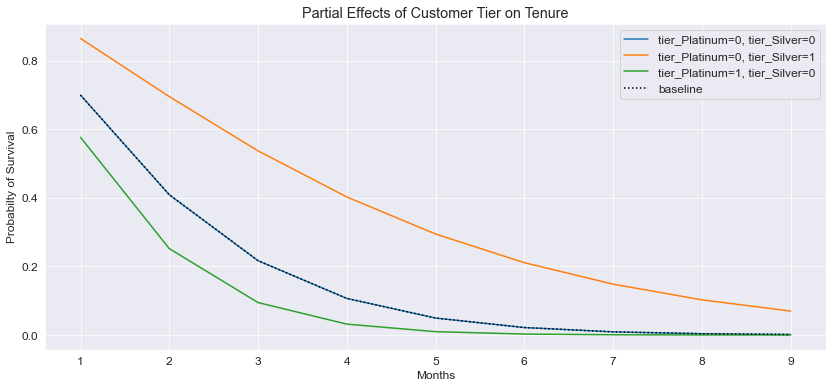

In [29]:
plt.figure(figsize = (14,6))
aft_model.plot_partial_effects_on_outcome(["tier_Platinum", "tier_Silver"], values=[[0,0],[0,1],[1,0]])
plt.title("Partial Effects of Customer Tier on Tenure")
plt.ylabel("Probabilty of Survival")
plt.xlabel("Months");

### Country 
The baseline country in the model is Canada. All countries have the same or lower tenure except for the Netherlands, which has a 7% longer mean/median enrollment. Spain has the lowest tenure, which is 22% lower than the mean/median baseline enrollment. The UK, US, and Germany have similar tenure as those from Canada.

The plot below shows the impact of some of the countries on tenure, accounting for the other covariates.

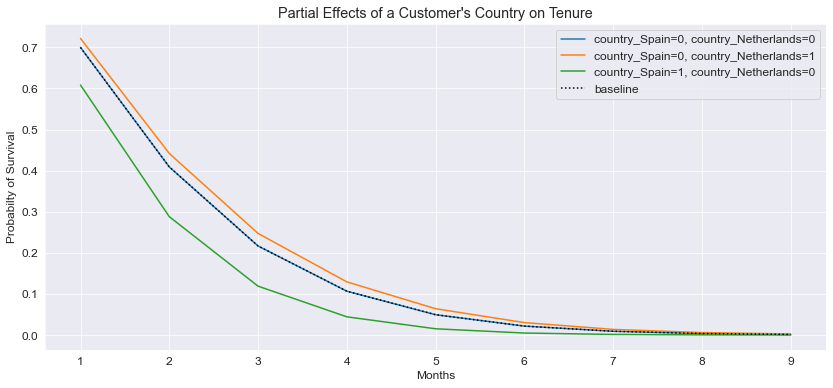

In [30]:
plt.figure(figsize = (14,6))
aft_model.plot_partial_effects_on_outcome(["country_Spain", "country_Netherlands"], values=[[0,0],[0,1],[1,0]])
plt.title("Partial Effects of a Customer's Country on Tenure")
plt.ylabel("Probabilty of Survival")
plt.xlabel("Months")
plt.legend(loc = "upper right");

### Source
The baseline source in the model is organic. Customers sourced from both referrals and partnerships had significantly longer enrollment periods compared to those that enrolled organically. Referrals had a 172% longer mean/median enrollment, whereas partnership customers had enrollments that were 60% longer. 

The plot below shows how the customer source impacts the probability of survival, accounting for the other covariates.

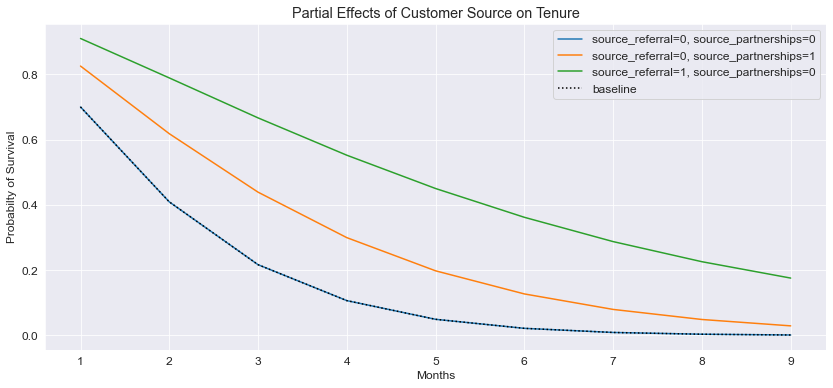

In [31]:
plt.figure(figsize = (14,6))
aft_model.plot_partial_effects_on_outcome(["source_referral", "source_partnerships"], values=[[0,0],[0,1],[1,0]])
plt.title("Partial Effects of Customer Source on Tenure")
plt.ylabel("Probabilty of Survival")
plt.xlabel("Months")
plt.legend(loc = "upper right");

## Q4: How many currently active subscriptions will still be active over the next three months (e.g. month 9, 10, 11)?

In [32]:
# filter down to just censored subjects to predict remaining survival
censored_subjects = X[~X['churn']]
censored_subjects_last_obs = y[~X['churn']]
censored_subjects.shape

(7492, 12)

In [33]:
# Predict the survival probability for the next three months for these active/censored customers
preds = aft_model.predict_survival_function(censored_subjects, 
                                     times = np.arange(1,4,1),
                                     conditional_after = censored_subjects_last_obs)

In [34]:
# Look at survival probabilities for five active customers
preds.iloc[:,0:5]

,8,19,28,30,31
1.0,0.770751,0.694711,0.694711,0.770751,0.617121
2.0,0.588973,0.476856,0.476856,0.588973,0.374820
3.0,0.446456,0.323651,0.323651,0.446456,0.224279


In [35]:
# Calculate the average survival probabiliy by month, multiply by the number of active customers, and round to
# the nearest customer
enrollment_predictions = round(preds.mean(axis = 1)*censored_subjects.shape[0],0)
print(enrollment_predictions)

1.0    5114.0
2.0    3578.0
3.0    2552.0
dtype: float64


In [36]:
# Calculate number of "churned" customers by month
customer_churn = df["tenure"].value_counts()

# Create list of months 
months = [month for month in range(12)]

# Create previous_customers variable beginning with all customers
previous_customers = len(df)

# Create active customers list beginning with all customers
active = [previous_customers]

# Loop through each month, calculate remaining customers and append to active list
for churn in range(1,len(customer_churn)):
    remaining_customers = previous_customers - customer_churn[churn]
    active.append(remaining_customers)
    previous_customers = remaining_customers

# Add predictions to active list
for enrolled_customers in enrollment_predictions.values:
    active.append(int(enrolled_customers))

In [37]:
pd.DataFrame({"month":months, "active customers":active})

,month,active customers
0,0,99944
1,1,48554
2,2,28433
3,3,20508
4,4,16249
5,5,13528
6,6,11715
7,7,10356
8,8,7492
9,9,5114


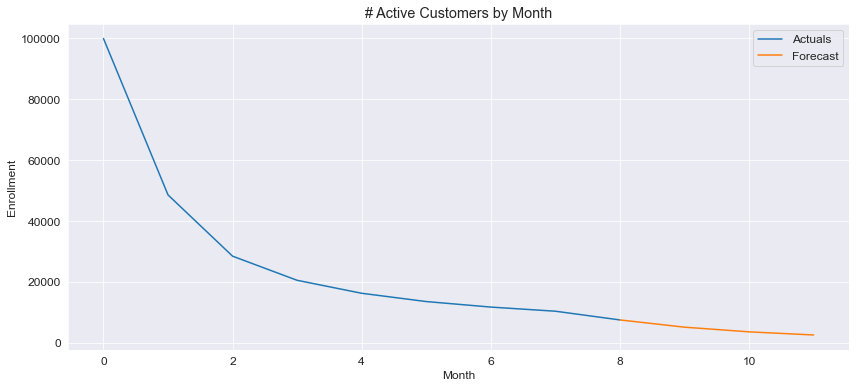

In [38]:
# Create plot with actual and forecasted enrollment

plt.figure(figsize=(14,6))
plt.plot(months[0:9],active[0:9])
plt.plot(months[8:], active[8:])
plt.legend(["Actuals","Forecast"])
plt.xlabel("Month")
plt.ylabel("Enrollment")
plt.title("# Active Customers by Month");

The total number of active customers drops from 7,492 after the first 8 months to 2552 three months later. 

## Concluding Remarks

Predicting churn rates beyond 9 months had highly variable results, depending on the model and selected hyperparameters. While the analysis above does provide estimates for months 10, 11, and 12, these estimates are highly unreliable. As more data is collected in the coming months, the models should be re-run and calibrated to the actual churn results.